<a href="https://colab.research.google.com/github/Yash-Yelave/Machine_Learning/blob/main/Loan_Approval_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.stats import ttest_ind, chi2_contingency




In [42]:
# Load dataset
data = pd.read_csv("/content/loan_approval_dataset.csv")
data.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [43]:
# Basic exploration
data.columns = data.columns.str.strip()

def explore(df):
    dimension = df.shape
    print("Our dataset has :")
    print(f"{dimension[0]} row \nand")
    print(f"{dimension[1]} column")
    print('\nInformations about the dataset :')
    print(df.info())
    print('\nCheck the missing values :')
    print(df.isna().sum())

explore(data)
print("\nDescriptive Statistics's :")
data.describe()

Our dataset has :
4269 row 
and
13 column

Informations about the dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   loan_id                   4269 non-null   int64 
 1   no_of_dependents          4269 non-null   int64 
 2   education                 4269 non-null   object
 3   self_employed             4269 non-null   object
 4   income_annum              4269 non-null   int64 
 5   loan_amount               4269 non-null   int64 
 6   loan_term                 4269 non-null   int64 
 7   cibil_score               4269 non-null   int64 
 8   residential_assets_value  4269 non-null   int64 
 9   commercial_assets_value   4269 non-null   int64 
 10  luxury_assets_value       4269 non-null   int64 
 11  bank_asset_value          4269 non-null   int64 
 12  loan_status               4269 non-null   object
dtypes:

,loan_id,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
count,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03
mean,2135.000000,2.498712,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06
std,1232.498479,1.695910,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06
min,1.000000,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00
25%,1068.000000,1.000000,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06
50%,2135.000000,3.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06
75%,3202.000000,4.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06
max,4269.000000,5.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07


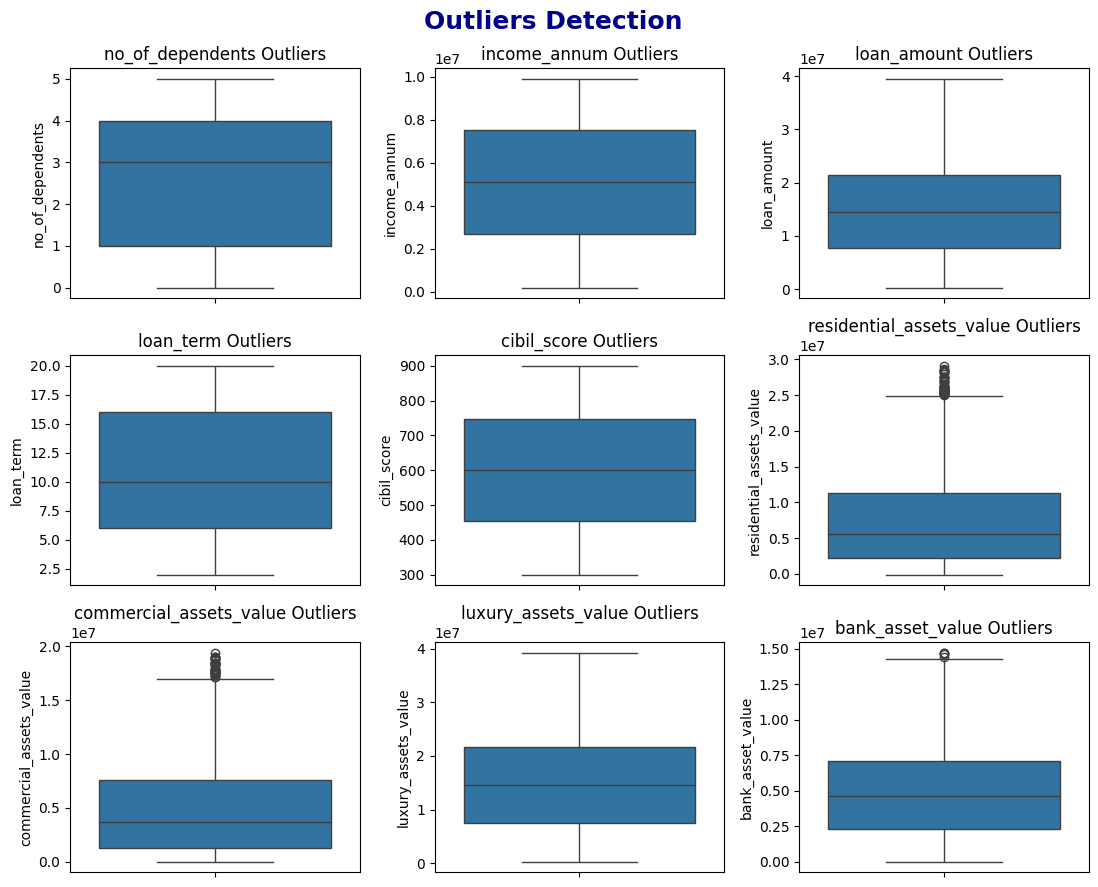

In [44]:
# Detect outliers
numerical = data.loc[:, data.columns != 'loan_id'].select_dtypes(include=["number"]).columns.to_list()
categorical = data.loc[:, data.columns != 'loan_status'].select_dtypes(include=["object"]).columns.to_list()
target = 'loan_status'

plt.figure(figsize=(11,9))
for i, col in enumerate(numerical):
    plt.subplot(3,3,i+1)
    sns.boxplot(data[col])
    plt.title(f"{col} Outliers")
plt.suptitle("Outliers Detection", fontsize=18, fontweight='bold', color='darkblue')
plt.tight_layout()
plt.show()

In [45]:
# Handle outliers
outliers_col = ['residential_assets_value','commercial_assets_value','bank_asset_value']

def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

for col in outliers_col:
    data = handle_outliers(data, col)

In [46]:
# Feature engineering
df = data[['loan_term','cibil_score',target]]
df['score_per_month'] = df['cibil_score'] / df['loan_term']
df['loan_status'] = df['loan_status'].map({'Approved': 1, 'Rejected': 0})

X = df[['score_per_month','loan_term','cibil_score']]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

/tmp/ipython-input-188386804.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score_per_month'] = df['cibil_score'] / df['loan_term']
/tmp/ipython-input-188386804.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loan_status'] = df['loan_status'].map({'Approved': 1, 'Rejected': 0})


In [47]:
target_col = y_train.name  # get the actual target column name

train_data = pd.concat([X_train, y_train], axis=1).dropna(subset=[target_col])
X_train_clean = train_data.drop(target_col, axis=1)
y_train_clean = train_data[target_col]

test_data = pd.concat([X_test, y_test], axis=1).dropna(subset=[target_col])
X_test_clean = test_data.drop(target_col, axis=1)
y_test_clean = test_data[target_col]

# Logistic Regression
model_LR = LogisticRegression(max_iter=1000)
model_LR.fit(X_train_clean, y_train_clean)

y_pred_LR = model_LR.predict(X_test_clean)

print("Logistic Regression Accuracy:", accuracy_score(y_test_clean, y_pred_LR))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_clean, y_pred_LR))
print("\nClassification Report:\n", classification_report(y_test_clean, y_pred_LR))


ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required by LogisticRegression.

In [49]:
# Decision Tree
dt_model = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))

ValueError: Input y contains NaN.

In [ ]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

In [ ]:
# Compare model performance
models = ['Logistic Regression', 'Decision Tree', 'Random Forest']
accuracies = [accuracy_score(y_test, y_pred_LR), accuracy_score(y_test, y_pred_dt), accuracy_score(y_test, y_pred_rf)]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['blue', 'green', 'orange'])

for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
             f"{accuracy * 100:.00f}%", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title("Model Accuracy Comparison")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.ylim(0, 1.1)
plt.show()